In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import xarray as xr

from pathlib import Path

import altair as alt
from altair.expr import datum

In [3]:
%load_ext watermark

In [4]:
%watermark --iversions

numpy     1.16.3
pandas    0.24.2
altair    3.2.0
xarray    0.12.0



In [5]:
from utils.load import load_dilution_data
from utils.calculate_metrics import (process_data, relative_errors, summary_errors)

# 1. Load the simulation data

In [6]:
dil_df, debug_info = load_dilution_data()

In [7]:
dil_df.head()

,flux,ID,BiGG_ID,author,sample_id,normalized_flux
0,-0.054344,ACALD,ACALD,Khodayari,0.2,-0.049474
1,-0.004107,ACALDtpp_ex,composed of ACALDtex and ACALDtpp,Khodayari,0.2,-0.003739
2,0.088129,ACKr,ACKr,Khodayari,0.2,0.080232
3,96.831733,ACONTa,ACONTa,Khodayari,0.2,88.154691
4,96.797201,ACONTb,ACONTb,Khodayari,0.2,88.123254


In [8]:
dil_df.sample_id = dil_df.sample_id.astype('str')

In [9]:
dil_df.query("author == 'Yao'").BiGG_ID.unique()

array(['GLCptspp', 'PGI', 'PFK', 'FBA', 'GAPD', 'PGK', 'PGM', 'ENO',
       'PYK', 'PDH', 'PTAr', 'ACKr', 'ACt2r', 'PPC', 'CS', 'ACONTa',
       'ACONTb', 'ICDHyr', 'AKGDH', 'SUCOAS', 'SUCDi', 'FUM', 'ME1',
       'ICL', 'MDH', 'NADTRHD', 'G6PDH2r', 'GND', 'RPE', 'RPI', 'TKT1',
       'TKT2', 'TALA', 'PGCD', 'GHMT2r'], dtype=object)

### Preprocess data

In [10]:
xdf = process_data(dil_df, author="Yao")

# 2. Calculate error metrics

In [11]:
x_rel_error = relative_errors(xdf, author="Yao")

In [12]:
x_norm_error = summary_errors(xdf, author="Yao")

# 3. Visualize

In [13]:
from utils.vis import heatmap, jitter_summary_chart

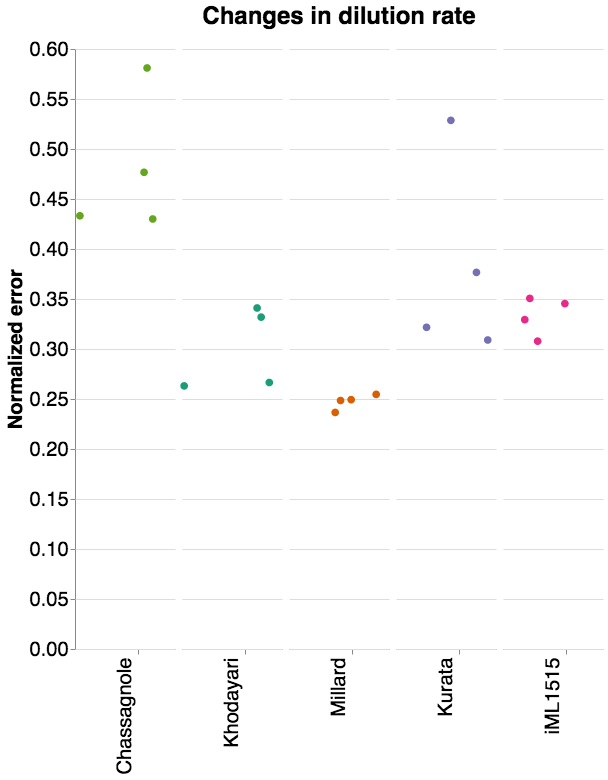

In [13]:
jitter_summary_chart(norm_error = x_norm_error, author = "Yao",
              title= "Changes in dilution rate",
              sort_list=["Chassagnole", "Khodayari", "Millard", "Kurata", "iML1515"],
              opacity = False,
              color_scheme = "dark2")

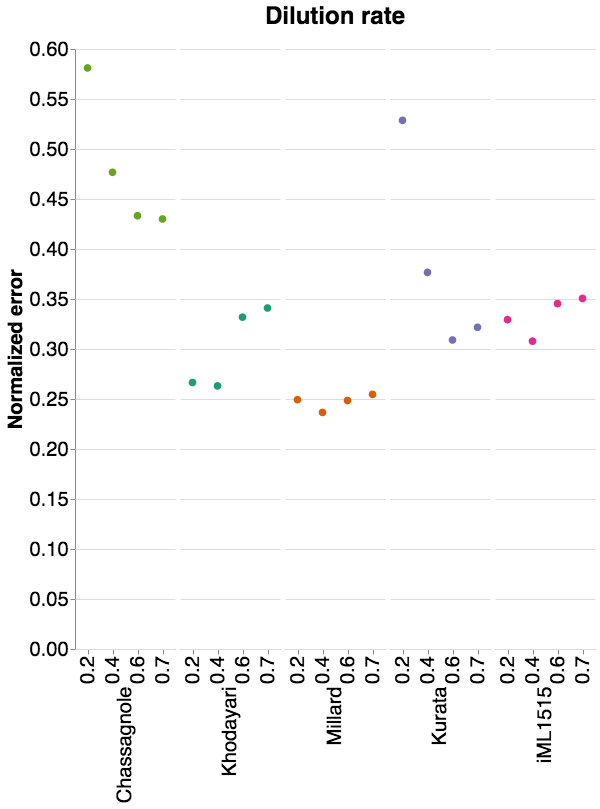

In [21]:
domain = [
        "Khodayari",
        "Millard",
        "Kurata",
        "iML1515",
        "Chassagnole",
        "Exp_iML1515",
    ]
range_ = [
        "#1b9e77",
        "#d95f02",
        "#7570b3",
        "#e7298a",
        "#66a61e",
        "#e6ab02",
    ]

author = "Yao"
sort_list=[ "Khodayari", "Millard", "Kurata","iML1515", "ECC2"],

source = x_norm_error.to_dataframe().reset_index()
if type(author) == list:
    source = source.query(f"author not in @author")
elif type(author) == str:
    source = source.query(f"author != '{author}'")

selector = alt.selection_single(empty="none", fields=["sample_id"])

opacity = alt.OpacityValue(1.0)

size = alt.condition(selector, alt.SizeValue(150), alt.SizeValue(60))

    
stripplot = (
    alt.Chart(source, width=100, height=600)
    .mark_circle()
    .encode(
        x=alt.X(
            "sample_id:O",
            title=None,
            #axis=alt.Axis(values=[0], ticks=True, grid=False, labels=False),
            scale=alt.Scale(),
        ),
        y=alt.Y("normalized_error:Q", title="Normalized error"),
        color=alt.Color("author:N", legend=None, scale=alt.Scale(domain=domain, range=range_)),
        column=alt.Column(
            "author:N",
            header=alt.Header(
                labelAngle=-90,
                titleOrient="top",
                labelOrient="bottom",
                labelAlign="right",
                labelPadding=3,
                labelFontSize=20,
                title="Dilution rate",
            ),
            sort=["Chassagnole", "Khodayari", "Millard", "Kurata", "iML1515"],
        ),
        size=size,
        opacity=opacity,
        tooltip=["author", "sample_id", "normalized_error"],
    )
    .configure_facet(spacing=5)
    .configure_view(stroke=None)
    .add_selection(selector)
    .transform_filter("datum.normalized_error !== null")
)

stripplot.configure_axis(labelFontSize=20, titleFontSize=20).configure_header(titleFontSize=24)


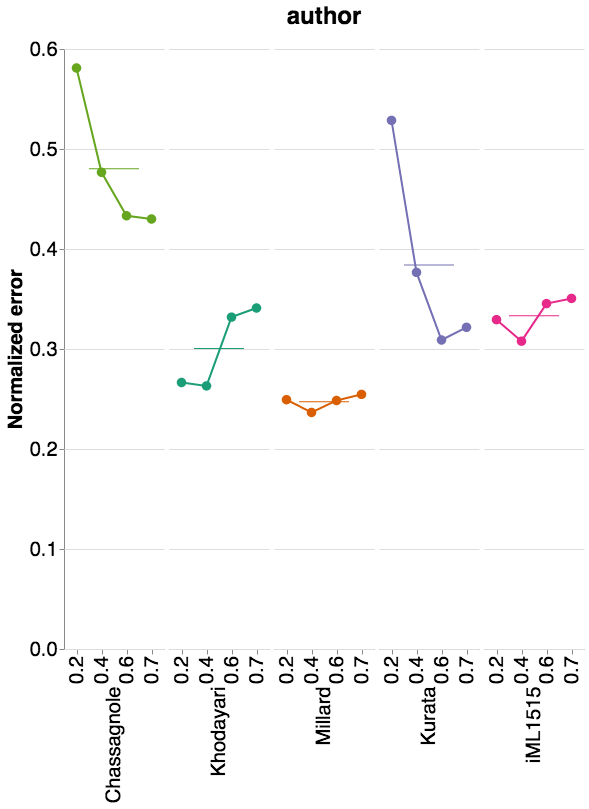

In [24]:
domain = [
    "Khodayari",
    "Millard",
    "Kurata",
    "iML1515",
    "Chassagnole",
    "Exp_iML1515",
]
range_ = [
    "#1b9e77",
    "#d95f02",
    "#7570b3",
    "#e7298a",
    "#66a61e",
    "#e6ab02",
]

author = "Yao"
sort_list = ["Chassagnole", "Khodayari", "Millard", "Kurata", "iML1515"]

source = x_norm_error.to_dataframe().reset_index()
if type(author) == list:
    source = source.query(f"author not in @author")
elif type(author) == str:
    source = source.query(f"author != '{author}'")

selector = alt.selection_single(empty="none", fields=["sample_id"])

opacity = alt.OpacityValue(1.0)

size = alt.condition(selector, alt.SizeValue(150), alt.SizeValue(90))


stripplot = (
    alt.Chart(width=100, height=600)
    .mark_circle()
    .encode(
        x=alt.X("sample_id:O", title=None, scale=alt.Scale(),),
        y=alt.Y("normalized_error:Q", title="Normalized error", axis=alt.Axis(tickCount=8)),
        color=alt.Color(
            "author:N", legend=None, scale=alt.Scale(domain=domain, range=range_)
        ),
        size=size,
        opacity=opacity,
        tooltip=["author", "sample_id", "normalized_error"],
    )
    .add_selection(selector)
)

line_plot = (
    alt.Chart()
    .mark_line()
    .encode(
        x=alt.X("sample_id:O", title=None, scale=alt.Scale(),),
        y=alt.Y("normalized_error:Q", title="Normalized error",axis=alt.Axis(tickCount=8)),
        color=alt.Color(
            "author:N", legend=None, scale=alt.Scale(domain=domain, range=range_)
        ),
    )
)


mean_tick = (
    alt.Chart()
    .mark_tick(width = 50)
    .encode(
        y = alt.Y("mean(normalized_error)"),
        color=alt.Color(
            "author:N", legend=None, scale=alt.Scale(domain=domain, range=range_)
        ),
    )
)

layer = (
    alt.layer(stripplot, line_plot, mean_tick, data=source)
    .facet(
        column=alt.Column(
            "author:N",
            header=alt.Header(
                labelAngle=-90,
                titleOrient="top",
                labelOrient="bottom",
                labelAlign="right",
                labelPadding=3,
                labelFontSize=20,
            ),
            sort=sort_list,
        )
    )
    .configure_facet(spacing=5)
    .configure_view(stroke=None)
    .transform_filter("datum.normalized_error !== null")
)

layer.configure_axis(labelFontSize=20, titleFontSize=20).configure_header(
    titleFontSize=24
)

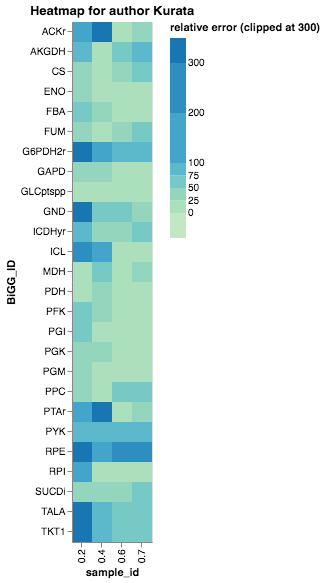

In [16]:
heatmap(x_rel_error, author = "Kurata")

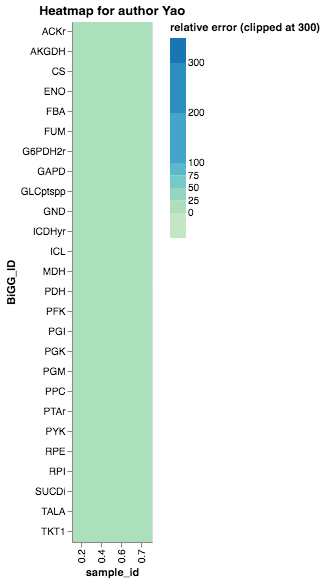

In [15]:
heatmap(x_rel_error, author = "Yao")